In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

Macro `_latex_std_` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('run', 'Latex_macros.ipynb')
 

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Common imports
import os

import mnist_helper
%aimport mnist_helper

mnh = mnist_helper.MNIST_Helper()

import class_helper
%aimport class_helper

clh= class_helper.Classification_Helper()

import training_models_helper as tmh
%aimport training_models_helper

tm = tmh.TrainingModelsHelper()

# Overview

## Goals

- In-depth exploration of Classification task
    - the target of the Classification task is a categorical variable

- Dealing with categorical variables
    - discrete *unordered* values, rather than continous as in Regression task


## Plan

- Introduce the Titanic challenge
    - driving example for Classification
    - categorical target
    - some categorical features

- First pass at the challenge
    - Naive approach, but makes the points
    - Restrict to **binary** categorical target/features (ony two discrete choices)
    
- Generalize to
    - multinomial targets (categorical with more than 2 choices)
    - categorical features with more than 2 classes


# Categorical data

A categorical variable
- has a finite number of discrete values
    - call each value a *category* or *class* (e.g., classification)
- There is *no* ordering relationship between categories
    - { "Red", "Green", "Blue" }  (set notation)
    - versus [ "Small", "Medium", "Large" ] (sequence notation)
        - *ordinal* if there is an ordering relationship, even in the absence of a magnitude

The Classification task has a categorical target

# Binary Classification: the Titanic challenge

We will introduce the Classification task using an historical event: the sinking of the Titanic.

(Also the subject of a famous movies)

Our task: given attributes of a passenger on the ship, predict whether the passenger survived.


This is a  *binary* classification problem as there are only two elements in the target class.

In general, there may be more than two categories: *Multinomial (or multi-class) classifiction*

Once you know how to do binary classification, it is easily adapted to multinomial classification.
  

## Problem statement

We will follow the Recipe for Machine Learning that we introduced last lecture.

First step: Problem statement -- borrowed  from [Wikipedia](https://en.wikipedia.org/wiki/RMS_Titanic)

>RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in 1912 after the ship struck an iceberg during her maiden voyage from Southampton to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it one of modern history's deadliest peacetime commercial marine disasters


The goal is to predict whether a passenger survives, based on passenger characteristics.
- target: { "Survive", "Not Survive" }
- features: vector of passenger characteristics

**Aside:** What does the Titanic have to do with Finance or Risk ?
- Defaults (Survival probability of a corporation)
    - Credit risk
- Mortgage pre-payment

## Performance measure

Our performance measure will be **accuracy**, the fraction of correct predictions.

$$
\textrm{Accuracy} = \frac{\textrm{number of correct predictions}}{\textrm{number of predictions} }
$$

There are several drawbacks with this definition, which we will address later.

But let's start with it for now.

## The Data

### Get the data
The data comes in two CSV format files
- train
- test

We will read them into a Pandas DataFrame.
- Observe our use of *relative paths* for file names
- Using relative rather than absolute paths is a requirement of your assignments!

### Initial Data Exploration

In [4]:
# Note the use of *relative path*; your assignments should all use relative rather than absolute paths
TITANIC_PATH = os.path.join("./external/jack-dies", "data")

train_data = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv") )
test_data  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv")  )


#### First look

Let's examine the first few records to get a feel for the shape of the data.

This will help us understand the features and the target.

In [5]:
train_data.columns
train_data.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target
    - 0 means passenger did not survive
    - 1 means passenger survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

How many observation are there ?


In [6]:
(num_obs, num_features) = train_data.shape
print("There are {nr} observations and {nf} attributes (including the target)".format(nr=num_obs, nf=num_features) )

There are 891 observations and 12 attributes (including the target)


The first thing to notice is that we have many fewer examples than the number of passengers
indicated in the problem statement.

We'll ignore this for now.

Let's try to understand the types of the attributes

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


**Non-numeric attributes**

We can see the non-numeric attributes (type is "object") are:
- `Name`
- `Sex`
- `Cabin`
- `Embarked`

**Data issues: missing attributes**

We can also see that we have some missing data issues to deal with.

Any attribute with less than num_obs values has observations with a missing value in the attribute
- `Age`
- `Cabin`
- `Embarked`

**Other issues**
- Shouldn't `Survived` be categorial rather than numeric ?
    - What about `Pclass` (we will re-visit)


Let's get a sense of the distribution of each attribute

(n.b., `describe` operates *only* on the numeric attributes)

In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- You can also observe the attributes with missing values by looking at the "count"
- You can clearly see that `Survived` is a binary, *integer* variable
- Only 38 % of the passengers survived ("mean")

In [9]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

##### Graphical exploration

**Distribution of each attribute**

Let's start by looking at the (unconditional) distribution of the target and some attributes

First let's look at them normalized (i.e, as fractions or probabilities)

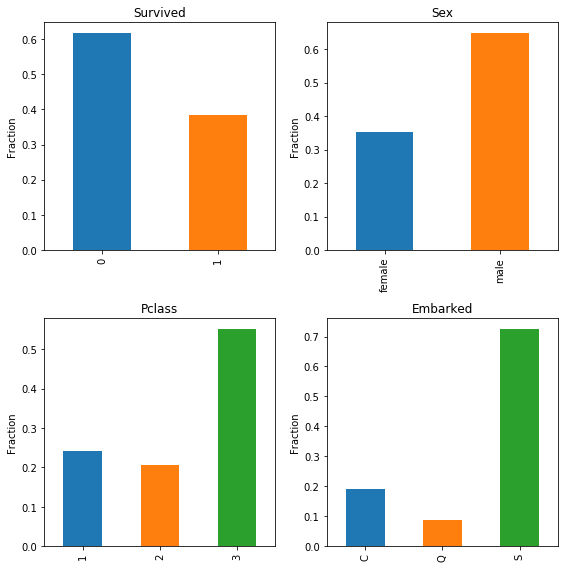

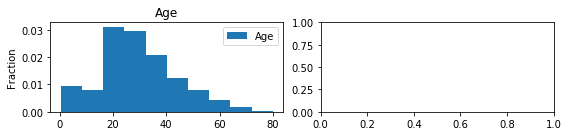

In [10]:
clh.plot_attrs(train_data, [ "Survived", "Sex", "Pclass", "Embarked" ], attr_type="Cat", plot=True, normalize=True)
clh.plot_attrs(train_data, [ "Age" ], attr_type="Num", normalize=True)

Next, let's look at them un-normalized, or absolute count

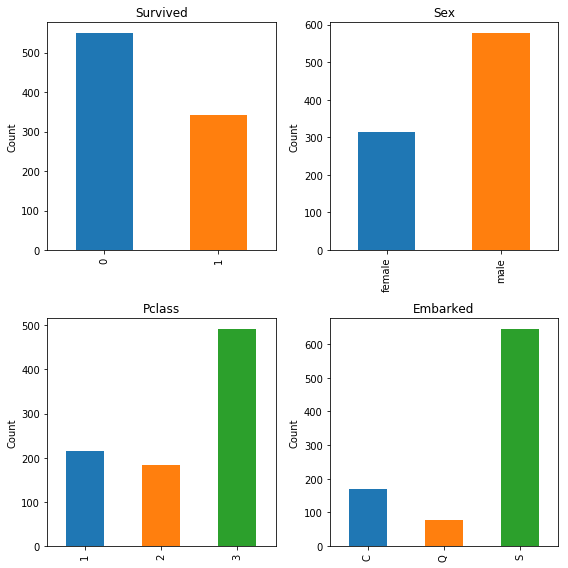

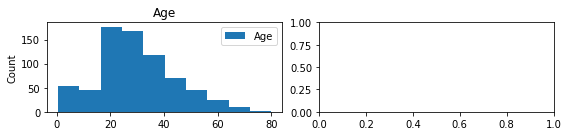

In [11]:
clh.plot_attrs(train_data, [ "Survived", "Sex", "Pclass", "Embarked" ], attr_type="Cat", plot=True, normalize=False)
clh.plot_attrs(train_data, [ "Age" ], attr_type="Num", normalize=False)

##### Conditional survival probability (condition on single attribute)

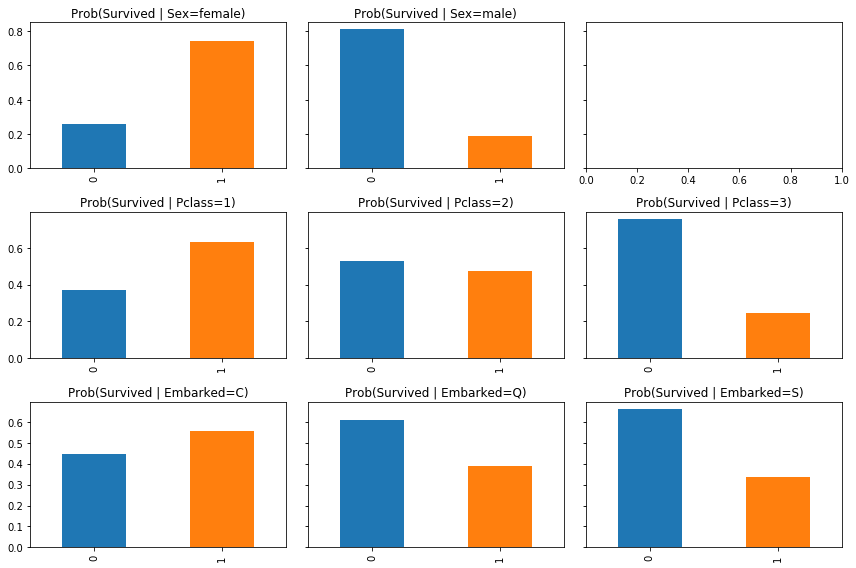

In [12]:
fig, axs = clh.plot_conds(train_data, [ ("Survived", { "Sex": "female"}),
                         ("Survived", { "Sex": "male"}),
                         None,
                         ("Survived", { "Pclass": 1}),
                         ("Survived", { "Pclass": 2}),
                         ("Survived", { "Pclass": 3}),
                        
                         ("Survived", { "Embarked":"C"}),
                         ("Survived", { "Embarked":"Q"}),
                         ("Survived", { "Embarked":"S"})
                       ],
                          share_y="row"
          )

# In case the figure is truncated in this slide, we will re-display it in the next (without the code)

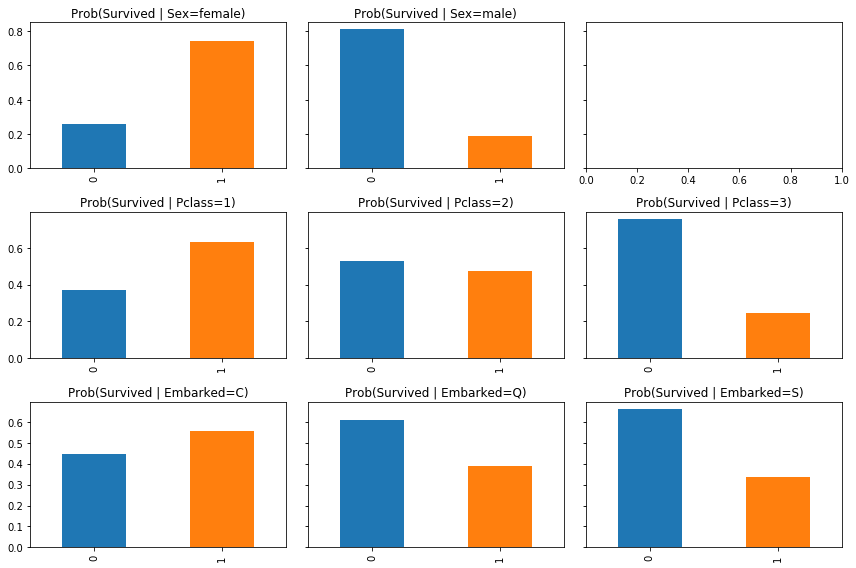

In [13]:
# Display the figure again, in it's own slide, so it is not truncated
fig

Interesting !
- Women are 3 times as likely to survive
- NOT being in the lowest Class doubles or triples your survival probability
- Embarking at Cherbourg increased your probability of surviving
    - WHY ? Is there a correlation between Class and point of embarcation maybe ?
    
Preview: There may also be lessons here for dealing with missing data

##### Conditional survival probability (condition on multiple attributes)

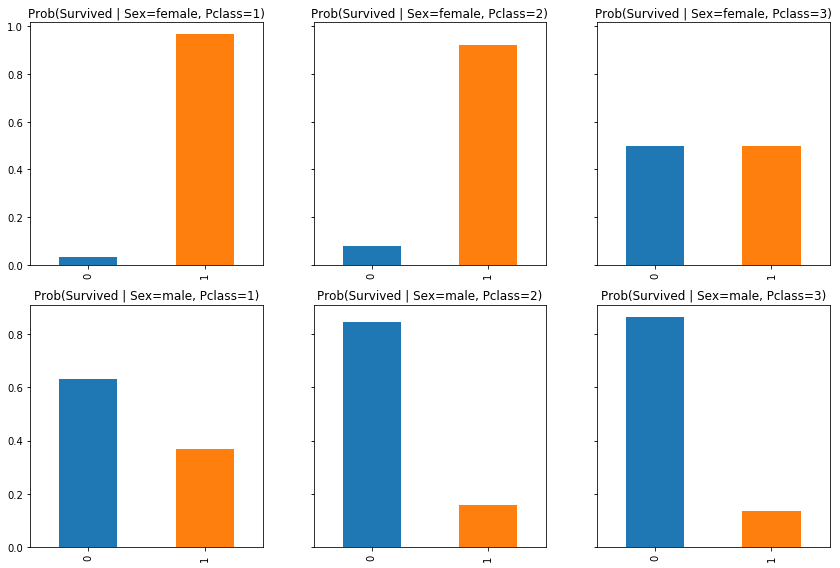

In [14]:
fig, axs = clh.plot_conds(train_data, [
                         ("Survived", { "Sex": "female", "Pclass": 1}),
                         ("Survived", { "Sex": "female", "Pclass": 2}),
                         ("Survived", { "Sex": "female", "Pclass": 3}),
    
                         ("Survived", { "Sex": "male", "Pclass": 1}),
                         ("Survived", { "Sex": "male", "Pclass": 2}),
                         ("Survived", { "Sex": "male", "Pclass": 3}),
                       ],
                          share_y="row"
                         )

# In case the figure is truncated in this slide, we will re-display it in the next (without the code)

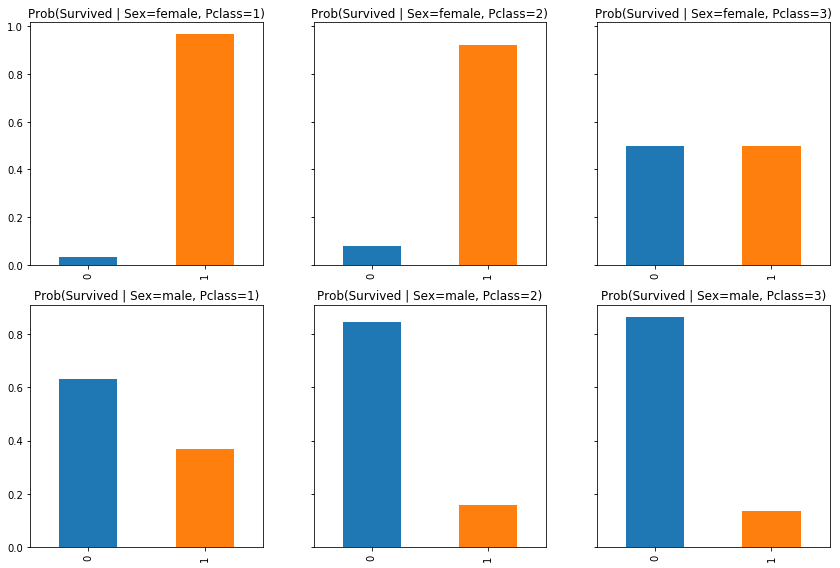

In [15]:
# Display the figure again, in it's own slide, so it is not truncated
fig

Remember that we thought being Female increased chances of Survive ?
- we can see now see that this was only true for Classes 1 and 2

<div class="alert alert-block alert-info">
    <b>Aside</b>:   How does pd.groupby() work ?

The Pandas Split-Apply-Combine pattern is very powerful
- This is very SQL-like, for those who have used databases
- Below is some simpler Pandas code to show exactly how it works

In [16]:
# Partition by the attribute "Sex"
males   = train_data[ train_data["Sex"] == "male"]
females = train_data[ train_data["Sex"] == "female"]

# Aggregate within each group: count,mean.  n.b., only doing this for the "Survived" column
count_males, count_females = males.shape[0], females.shape[0]
survival_males, survival_females = males["Survived"].mean(), females["Survived"].mean()

print( "male\t{c}\t{m:0.4f}".format(c=count_males, m=survival_males) )
print( "female\t{c}\t{m:0.4f}".format(c=count_females, m=survival_females) )

# Or, use the pd.groupby
train_data.groupby("Sex").agg(["mean", "count"])["Survived"]


male	577	0.1889
female	314	0.7420


,mean,count
Sex,,
female,0.742038,314
male,0.188908,577


### Test data

The train/test split was done for us: it came as two separate files

We might later choose to combine the two and do our own split (or better yet: multiple splits) but for now, we'll take what we are given

## Prepare the data: tranformations (including cleaning)

Our first model will use the following features
- Pclass
- Sex
- Age
- SibSp: passenger's number of "same-level" relatives (Sibling, Spouse)
- Parch: passenger's number of "different-level" relatives (Parent, Child)
- Fare

The first step will be to transform the data into a usable form.

We will do minimal transformation for now (more to come in the module on Data Transformations)
- clean the data: deal with missing values
- convert the categorical, binary attribute "Sex" to a number: 0:male, 1: female

(We include Data Cleaning as a transformation, rather than treating it as a separate step)

This is also very naive (and, technically wrong !  Ask me later !) but it will allow us to make our key points with minimum distraction.

### Data cleaning transformation

Our initial data exploration revealed some attributes with missing data
- Age
- Cabin
- Embarked

We will address various strategies for dealing with missing data in the module on Data Transformations.

For now, we will take a very simple (and naive) approach
- for numeric attributes: use the median value
- for non-numeric attributes: use the most frequent value

### Feature engineering: transformations to add features

**Preview of coming attractions (subsequent lecture)**

We won't perform feature engineering now other than to point out some interesting possibilities.

This may help you as  you tackle problems between now and the lecture on Transformations.

**Cabin**

Might the Cabin location be associated with Surivival ?  

Note that the front of the ship went down first.

If you are a diligent Data Scientist you can find this image, which is revealing
- Worst cabins (pink, Third class) were dispersed between front and back
- Best cabins (white, First class) were dispersed between above/below deck
- Mid cabins(yellow, Second Class) were *not* near front of ship
![Titanic cabins](images/Titanic_cabin_layout.jpg)

**Age**

For linear estimators ($\Theta^T \x$)
each increment in value of a feature impacts the prediction.

So an example with feature value $2 * \x_j$ has twice the impact of an example with feature value $\x_j$.

But is this really true ? Does even a small increment in Age (e.g, from 25 to 26 years) matter ?

We might be able to improve things using a "bucket" transformation:
- all Ages within a range (bucket) are given the same value
- model will try to make distinctions *across* buckets, but not *within* a bucket.

In [17]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


Wow ! Children below the age of 15 (bucket 0.0) had a much better chance of survival.  

(And it doesn't pay to be old when disaster strikes!)

We would be hard pressed to see this using Age as a continous variable

**Embarked**

The Embarked attribute tells us where the passenger boarded:
- C=Cherbourg, Q=Queenstown, S=Southampton.

Could this be a predictor of Survival ?

### Categorical Transformation: Binary variable special case

We will need to transform our categorical features into numbers.

The way to treat non-numeric values is not obvious and there are many *wrong* ways to do it.

Fortunately, binary non-numerical data is an an easy special case (0 or 1 values)

We will initially limit ourselves to binary targets and features.

- This will allow us to focus on the Classification task without distraction.

- We will make a second pass to generalize to categorical variables with more than 2 classes.

Which variables are categorical ?

We can (and should) apply *human logic* to discern which variables are categorical.

But a little code can help:

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
AgeBucket      714 non-null float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.6+ KB


- All of the columns described as `object` are non-numerical and hence likely suspects
    - `Name`, `Sex`, `Cabin`, `Embarked`
    
- But, as observed during our first look, some numeric columns are *also* candidates
    - `Survived`
    - `PassengerId`, `Pclass`
        - Key determinant: is there an ordering relationship ?
        
- In particular, our target `Survived` which should be categorical, has beeen encoded as an integer {0,1}.

- So, by luck (or bad encoding) we don't have to convert the categorical Survived feature to a binary digit.

- We will have to convert `Sex` (this is the only categorial feature we retain for our initial model)
 

### A sophisticated pipeline to implement all transformations

- the same transformations need to be applied to
    - the Train data  set (and each subset used during Cross Validation)
    - the Test data
    - the transformations are "fit" on the Train set and applied to the Test set
 
We will implement both the Data Cleaning and Categorical transformations via an
`sklearn` pipeline
- briefly introduced in last lecture.
- by centralizing all the transformations in a pipeline, we can apply it consistently to all sets

**Pipeline refresher** 

- A pipeline implements a sequence of transformations
- `sklearn` allows Pandas DataFrames to be transformed too, not just NumPy arrays !
    - using *custom* transformations
    - the standard `sklearn` transformations produce NumPy arrays.
- Our plan
    - create one pipeline for the Numeric features
    - create a separate pipeline for the Categorical features
    - create a "union" pipeline that implements both the Numeric and Categorical pipelines
       

#### The numeric pipeline

- select DataFrame columns identified as Numeric (variable `num_features`)
- perform a "missing value" transformation
    - replace missing value with median value of the feature

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

num_features = ["Age", "SibSp", "Parch", "Fare"]

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector( num_features )),
        ("imputer", SimpleImputer(strategy="median")),
    ])

Let's see what the numeric pipleine produces.

Note: it produces a NumPy array because the final transformer (`SimpleImputer`) does it

In [20]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

#### The non-numeric pipeline
- select DataFrame columns identified as Categorical (variable `cat_features`)
- perform a "missing value" transformation
    - replace missing value with the value of the feature that occurs most often
- perform a "to categorical" transformation on `Sex`

**WARNING**: I'm doing a little cheating in this code by ignoring all categorical features other than `Sex`

In [21]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

class SexToInt(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        I am really cheating here ! Am ignoring all columns except for "Sex"
        """
        
        # To see that I am cheating, look at the number of columns of X !
        print("SexToInt:transform: Cheating alert!, X has {c} columns.".format(c=X.shape[-1]) )
        
        sex = X["Sex"]
        X["Sex"] = 0
        X[ sex == "female" ] = 1
        
        return(X)

cat_features = ["Sex", "Pclass" ]

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector( cat_features )),
        ("imputer", MostFrequentImputer()),
        ("sex_encoder", SexToInt() ),
    ])

Let's see what the categorical pipeline produces

Note: it produces a DataFrame because all elements of the pipeline produce DataFrames

In [22]:
cat_pipeline.fit_transform(train_data).head()

SexToInt:transform: Cheating alert!, X has 2 columns.


,Sex,Pclass
0,0,3
1,1,1
2,1,1
3,1,1
4,0,3


`FeatureUnion` glues together the Numeric and Categorical transformations along column dimension

#### The Union pipeline: both numeric and non-numeric pipelines together

In [23]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Let's look at the result of applying the `preprocess_pipeline`

In [24]:
X_train = preprocess_pipeline.fit_transform(train_data)

X_train.shape
X_train

# X_train is now an ndarray, so really can't discern columns, but are in same order as in Feature Union
# so first the num_features, then cat_features
# Can verify this by looking at train_data
all_features = num_features.copy()
all_features.extend(cat_features)
train_data.loc[:, all_features ] .head()

SexToInt:transform: Cheating alert!, X has 2 columns.


(891, 6)

array([[22.    ,  1.    ,  0.    ,  7.25  ,  0.    ,  3.    ],
       [38.    ,  1.    ,  0.    , 71.2833,  1.    ,  1.    ],
       [26.    ,  0.    ,  0.    ,  7.925 ,  1.    ,  1.    ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ,  1.    ,  1.    ],
       [26.    ,  0.    ,  0.    , 30.    ,  0.    ,  1.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ,  0.    ,  3.    ]])

,Age,SibSp,Parch,Fare,Sex,Pclass
0,22.0,1,0,7.2500,male,3
1,38.0,1,0,71.2833,female,1
2,26.0,0,0,7.9250,female,3
3,35.0,1,0,53.1000,female,1
4,35.0,0,0,8.0500,male,3


## Select and Train the model

OK, we have identified features and now want to predict Survival. 

How do we do it ?

### Logistic Regression: high level view

We will introduce a model for Binary Classification called Logistic Regression.

Binary Logistic Regression produces a probability $\hat{p}^\ip \in [0,1]$ that example $i$ is in 
the class encoded with $1$ ("class 1").

From the probability $\hat{p}^\ip$ we produce the prediction $\hat{\y}^\ip \in C$.

Convert $\hat{p}^\ip$ into Classification prediction $\hat{y}^\ip$

$$
\hat{y}^\ip = 
\left\{
    {
    \begin{array}{lll}
    0 & \textrm{if } \hat{p}^\ip   < 0.5  & \text{Negative} \\
    1 & \textrm{if } \hat{p}^\ip \ge 0.5  & \text{Positivve}
    \end{array}
    }
\right.
$$

We will re-visit the choice of threshhold $0.5$ at a later time.

How do we compute $\hat{p}$ ?

$$\hat{p} = \sigma(\Theta^T \x)  $$
where $\sigma$,  the *logistic function*, is:
$$
\sigma(s)  ={1 \over { 1 + e^{-s}} }
$$

Let's see what this function looks like


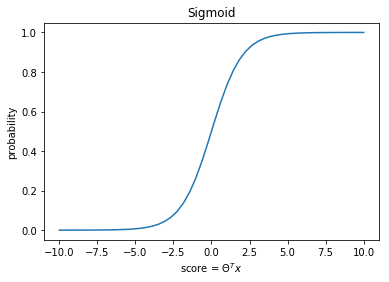

In [25]:
s = np.linspace(-10,10, 50)
sigma_s = 1/(1 + np.exp(- s))

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
_= ax.plot(s, sigma_s)
_= ax.set_title("Sigmoid")
_= ax.set_xlabel("score = $\Theta^T x$")
_= ax.set_ylabel("probability")

The logistic function converts a score 
$$s = \Theta^T \x$$
which has an unbounded range,  into values in the range $[0,1]$ which can
then be interpretted as probabilities.

The name Logistic Regression comes from the use of the logistic function applied to the linear $\Theta^T \x$.

This function is also called the *sigmoid* function and will reappear in the Deep Learning part of the  course.

$\hat{p} = \sigma(\Theta^T \x)  $

Can be interpretted as
- using template matching on the features $\x$ to produce a "score" $s = \Theta^T \x$
- convert the score into a probability with the sigmoid function

This interpetation will also reappear in the Deep Learning part of the course.

We will relate Logistic Regression to Linear Regression 
in a later section of the lecture.

For now, let's stick with this intuitive explanation.

### Cost function for Binary Logistic Classification: Binary Cross Entropy

As usual, we will treat Logistic Regresson as an optimization problem:
- solve for $\Theta$ that minimizes average loss across the training set.

The loss for example $i$ will be defined as
$$
\loss^\ip_\Theta =
\begin{cases}
- \log(\hat{p}) & \textrm{if } & \y^\ip = 1 \\
- \log(1-\hat{p})     & \textrm{if } & \y^\ip = 0 \\
\end{cases}
$$

Note the negative signs:
- the term being negated is a Utility (which we want to maximize)

Because only one of $\y^\ip$ and $(1-\y^\ip)$ is non zero, we  can re-write this as

$$
\loss^\ip_\Theta = - \left( y^\ip*\log(\hat{p}^\ip) + (1-\y^\ip) * \log(1-\hat{p}^\ip) \right)
$$


This expression is referred to as Binary Cross Entropy; it and the multi-class version
will become quite familiar going forward.

**Intuition (case $\y^\ip =1$)**
- since probabilities are no more than $1$, log probabilities are non-positive
- we want $\log(\hat{p}^\ip)$ to be very close to $0$; i.e., for $\hat{p}^\ip$ to be close to $1$
- so minimize the loss for positive example (i.e, $\y^\ip = 1$) when we predict $\hat{p}^\ip$ to be close to $1$

The Loss for the entire training set is simply the average (across examples) of the Loss for the example

$$
\loss_\Theta  = { 1\over{m} } \sum_{i=1}^m \loss^\ip_\Theta
$$

### Why didn't we use Accuracy (the Performance Metric) as our Cost ?

- Per example accuracy is binary: you are either correct or incorrect
- This means that unless we predict $\hat{p}^\ip = 1$ for a positive example, we are *incorrect*
    - There is no *degree* of incorrectness
    - we are equally incorrect whether $\hat{p}^\ip = (1 - .0001)$ or $\hat{p}^\ip =.0001$ 

So accuracy is missing some important properties
- continuity
- differentiable
    - being able to compute derivatives will be a **crucial** requirement for Deep Learning

So think of Binary Cross Entropy as a continuous analog of Accuracy.

# Titanic: let's predict !


In [26]:
y_train = train_data["Survived"]

### Logistic Regression classifier

Let's instantiate a `LogisticRegression` classifier

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, preprocessing, model_selection 

# New version of sklearn will give a warning if you don't specify a solver (b/c the default solver -- liblinear -- will be replaced in future)
logistic_clf = linear_model.LogisticRegression(solver='liblinear')

**More models, more fun ! Same price !**

Although the focus of this lecture is on Logistic Regression, it turns out to be just as
easy to run *multiple* models as it is one !

So we will solve the Titanic challenge with multiple models as an illustration, but we will
not delve into these other models.

**SVM Classifier**

In [28]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")

**Random Forest Classifier**

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

### Train the models

We will train all the models at once.

This demonstrates the power of a consistent API: 
- training several models is no more difficult than training one.

In [30]:
for name, clf in { "Logistic": logistic_clf,
                   "SVM": svm_clf,
                   "Random Forest": forest_clf
                 }.items():
    
    # Transform the data
    X_train = preprocess_pipeline.fit_transform(train_data)
    _= clf.fit(X_train, y_train)
    
    X_test = preprocess_pipeline.transform(test_data)
    y_pred = clf.predict(X_test)

    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print("Model: {m:s} avg cross val score={s:3.2f}\n".format(m=name, s=scores.mean()) )

SexToInt:transform: Cheating alert!, X has 2 columns.
SexToInt:transform: Cheating alert!, X has 2 columns.
Model: Logistic avg cross val score=0.79

SexToInt:transform: Cheating alert!, X has 2 columns.
SexToInt:transform: Cheating alert!, X has 2 columns.
Model: SVM avg cross val score=0.73

SexToInt:transform: Cheating alert!, X has 2 columns.
SexToInt:transform: Cheating alert!, X has 2 columns.
Model: Random Forest avg cross val score=0.80



The (average) accuracy of the various models is in the range of 70% to 80%

**Reminders**
- Use Cross Validation
    - out of sample performance
    - confidence interval
    
- Be sure to run the test set through the pipeline that was fit to the train set !

## Prediction

The model output $\hat{p}^\ip$ is a probability that example $i$ is in the Positive class.

Use some threshhold on $\hat{p}^\ip$  to convert the output
to a category in { Positive, Negative }.

We will discuss the choice of threshhold in a later lecture but, for now:
- it is safe to imagine choosing the category with maximum probability.

## Error Analysis

Cross validation gives you a metric for how well the model performed on the Test set *at a high level*.

You will gain deeper insight into the Classification task by analyzing individual predictions.

You can do this by 
- going through each test example
- determine whether the prediction is correct for the example

Is there some class for which the predictions are much less succesful than others ?

This is a signal to improve your model
- perhaps by adding features that aid prediction for the trouble classes.


There is some standard terminology for analyzing classification predictions.

For binary classification, to be concrete, let's call the two classes Positive (P) and Negative (N).

Let's create a table
- the row labels correspond to the predicted class
- the column labels correspond to the target (actual) class

In pictures:
$$
\begin{array}{lll}
\\
           & \textbf{P} &  \textbf{N} \\
\textbf{P} & \text{TP}         & \text{FP} \\
\textbf{N} & \text{FN}         & \text{TN} \\
\end{array}
$$

- The entry labelled True Positive (TP) denotes the number of test examples
    - that were correctly predicted as Positive
- The entry labelled as False Positive (FP) denotes the number of test examples
    - that were incorrectly predicted as Positive
- The entry labelled True Negative (TN) denotes the number of test examples
    - that were correctly predicted as Negative
- The entry labelled False Negative denotes the number of test examples
    - that were incorrectly predicted as Negative

So

$$\textrm{Accuracy} =  { \text{TP} + \text{TN} \over  \text{TP} + \text{FP} + \text{TN} + \text{FN} } $$

The False Positive (FP) and False Negative (FN) are our errors.

If the incorrectly predicted examples share something in common
- this may indicate a problem in our model
- needs to be corrected, perhaps through feature engineering.

# What if the target has more than 2 classes ? Multinomial Classification

So far, we have a binary classifier.  

What to do if the target classes has more than 2 classes ?

Let $C$ denote the set of discrete values for the target variable.


When $|| C || > 2$ this is called **Multinomial** or **Multiclass** Classification


## One versus all, One versus one
Some models (e.g. Decision Trees) can handle Multinomial classification directly.

For those that can't, we can adapt a binary classifier:
- One versus All (**OvA**):
    - create $K = ||C||$ binary classifiers, one for each class label
        - Use the $i^{th}$ binary classifier to predict: Is $i$, or is not $i$
    - predict the class whose binary classifier yields the highest probability
- One versus One (**OvO**)
    - create $ K \cdot (K-1)/2$ binary classifiers, one for each pair of class labels
    - predict the class that wins in the most paired classifications
    
 

In One versus All, we compute a score for each $c \in C$:
$$ 
s_{(c)} = \Theta_{(c)}^T \cdot \x 
$$ 

where
- $s_{(c)}$ denotes the score for the binary "c" classifier that predicts $c$ or not $c$
- $\Theta_{(c)}$ are the parameters of the "c" classifier

Let's be clear on the number of coefficients estimated in One versus All:

For the digit classification problem where there are $C = 10$ classes
the number of of parameters is *10 times* that of a binary classifier.

Fortunately, `sklearn` hides all of this from you.

What you *should* realize is that $||C||$ models are being fit, each with it's own parameters.

*Geron page 130*

>Scikit-Learn	detects	when	you	try	to	use	a	binary	classification	algorithm	for	a	multiclass	classification
task,	and	it	automatically	runs	OvA	(except	for	SVM	classifiers	for	which	it	uses	OvO).


## Softmax Regression

When we had a single binary classifier, we converted the score to a probability via the sigmoid function.

In multinomial classification
- we need a way to convert the set of per-class scores 
$$\{ s_{(c)} | c \in C \}$$
into a probability vector $\hat{\mathbf{p}}$ of length $||C||$.

The softmax function is the multinomial analog of the sigmoid function for binary values.



$$
\begin{array}{lll}
\hat{\mathbf{p}}_c  & = & \frac{\textrm{exp}( s_{(c)}(\x) )}  { \sum_{c=1}^{||C||} {\textrm{exp}( s_{(c)}(\x) )}}
\end{array}
$$

You can see that each $\hat{\mathbf{p}}_c \in [0,1]$ and that
$\sum_{c \in C} { \hat{\mathbf{p}}_c } = 1$ so $\mathbf{p}$ is indeed a probablility vector.


## Prediction

We can choose the class $c$ with the largest value in $\hat{\mathbf{p}}$ as our prediction
$$
\argmax{c} \hat{\mathbf{p}}_c 
$$


# One hot encoding (OHE)
$
\newcommand{\v}{\mathbf{v}}
$

Categorical variables can have more than 2 classes.

The way to represent a categorical variable $v$ with $||C||$ classes is with a 
vector $\v$ of length $||C||$.

$\v$ will have the property of being all zero *except* at a single index $j$ where $\v_j = 1$.

Hence the name *one hot* encoding.

We need to create a mapping $m$ from class $c \in C$ to  integers $\in \left[ \, 1, ||C|| \,\right]$.

This will enable us to associate an integer with a class label.

For example $i$, suppose $v$ has class label $c$.

Then $\v^\ip$ is defined as
$$
\begin{array}[lll]\\
\v^\ip_j & = & 1 & \text{ if } j = m(c) \\
\v^\ip_j & = & 0 & \text{ if } j \ne m(c) \\
\end{array}
$$

**n.b., we may slip into writing $\mathbf{v}^\ip_c$ rather than $\mathbf{v}^\ip_{m(c)}$**
- since $c$ is a category (non-numeric) and $m(c)$ is an integer this is unambgious

The categorical variable $v$ was replaced with $||C||$ binary variables $\v_1, \ldots, \v_{||C||}$.
- for each example $i$: there is exactly $1$ index $j$ such that $\v_j = 1$
- if feature $\v$ of example $i$ was from the $j^{th}$ class in $C$, then $\v^\ip_j = 1$

Each of the new *binary* features is called an *indicator* or *dummy* variable.


This is called **one hot encoding (OHE)** of a variable.

We can use OHE on variables, whether they are targets or features.

Let's see what $\v$ looks like on a number of examples, one for each possible class $c \in C$:

$$
\begin{array}{cccc}\\
&    & \v_1 & \v_2 & \v_3 & \ldots & \v_{||C||} \\
&m(c)=1 & 1    & 0    & 0    &        & 0    \\
&m(c)=2 & 0    & 1    & 0    &        & 0    \\
&m(c)=3 & 0    & 0    & 1    &        & 0    \\
& \ldots \\
&m(c)=||C|| & 0    & 0    & 0    &        & 1    \\
\end{array}
$$


To be concrete let's consider a data set with
- one numeric variable $x_0$
- categorical variable $x_1$ ("Gender") from categories $C_{(1)} = \{ "Male", "Female" \}$
- categorical variable $x_2$ ("Location")from categories $C_{(2)} = \{ "Urban", "Suburban", "Exurban" \}$

And a few rows from our data set

$
  \X' = \begin{pmatrix}
  \mathbf{const} & \mathbf{Gender} & \mathbf{Location} \\
  1 & Female & Urban \\ 
  1 & Female & Exurban \\ 
  1 & Male & Exurban \\ 
  1 & Male & Suburban \\ 
   \vdots \\
  \end{pmatrix}
$

After our One Hot Encoding we get

$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \mathbf{Is Female} & \mathbf{Is Male} & \mathbf{Is Urban} & \mathbf{Is Suburban} & \mathbf{Is Exurban}\\
  1 &  1 & 0 & 1 & 0 & 0 \\ 
  1 &  1 & 0 &  0 & 0 & 1\\ 
  1 &  0 & 1 &  0 & 0 & 1 \\ 
  1 &  0 & 1 &  0 & 1 & 0 \\ 
   \vdots \\
  \end{pmatrix}
$

Notice that the number of features has increased.

Specifically: a single categorical variable $x_j$ from a category $C = \{ c_1, c_2, \ldots \}$ of size $||C||$ 
- has been replaced by $||C||$ new varibles
   - $\text{Is } c_1$
   - $\text{Is } c_2$
   - $\vdots$
   - $\text{Is } c_{||C||}$
   


## One-Hot encoding of target 

Although it is pedantically convenient to think of multinomial classification as $||C||$ separate binary
classifiers, in reality we are fitting one classifier (with $||C||$ *sets* of parameters)

OHE turns the target from a scalar into a vector $\y$ of length $||C||$.

One way to think about this is that each target $\y^\ip$ is now a probability distribution, with all the mass concentrated at one point.


## One-Hot encoding of a feature

We can apply one hot encoding to features as well, as illustrated in the example above.

**Warning**: Depending on the model: 
- we may fall into the Dummy Variable Trap
when using OHE on *features*
- More in a moment.

# Cost function for Multinomial Logistic Classification: Cross Entropy

With the target now encoded as a vector $\y$ we can write the cost function per example as

$$
\loss^\ip_\Theta = - \sum_{c=1}^{||C||}
\left(
{ \y_c^\ip * \textrm{log} (\hat{\mathbf{p}}_c^\ip)}
\right)
$$

This is the multinomial analog of Binary Cross Entropy and is called **Cross Entropy**.


This is called the **Cross Entropy** Cost Function.

# Titanic revisited: OHE  features

Rather than representing the Sex feature as a binary value as we did originally 

`class SexToInt(BaseEstimator, TransformerMixin):`

    ...
    
    def transform(self, X, y=None):
        sex = X["Sex"]
        X["Sex"] = 0
        X[ sex == "female" ] = 1`
        
we will use one hot encoding.

## Titanic categorical features, without cheating

Can anyone spot where we "cheated" on the categorical feature in our first pass at the Titanic ?

- Our categorical pipeline treated `Sex` as the *only* categorical variable 
    - might there be other categorical variables ?
    - `Pclass` ?
        - How different is `Pclass == 2` from `Pclass == 1` ?
        - What if the classes were labeled `Pclass = 100` and `Pclass == 200` ?
- We encoded `Sex` with a binary integer
    - In general, it's best to use One Hot Encoding, resulting in two indicator features
    - This worked out (as we'll see) because Linear Regression needs a special form of OHE


We will now treat all features in the `cat_features` list as categorical in our pipeline

In [31]:
cat_features

['Sex', 'Pclass']

In [32]:
# Categorical pipleine, using OHE
from sklearn.preprocessing import OneHotEncoder 

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector( cat_features )),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

The `cat_pipeline` now creates $5$ indicators whereas the old one created only 1
- The `Sex`attribute is now 2 indicators ("Is Female", "Is Male")
- The `Pclass` attribute is now 3 indicators ("Is class 1", "Is class 2", "Is class 3")

Let's look at the first couple of training examples after OHE has been applied.

We will show the encoding along with the corresponding class labels.

In [33]:
# Run the categorial pipeline
cat_ndarray = cat_pipeline.fit_transform(train_data)

# Let's examine the first first rows of the ndarray, and relate them to the same rows in the DataFrame, 
# -- n.b., with the DataFrame, we can see the column names
num_to_see = 7

print(cat_features[0] + ":\n")
cat_ndarray[:num_to_see, :2]

train_data.loc[:, [ cat_features[0] ] ].head(num_to_see)

Sex:



array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

,Sex
0,male
1,female
2,female
3,female
4,male
5,male
6,male


In [34]:
print(cat_features[1] + ":\n")
cat_ndarray[:num_to_see, -3:]
train_data.loc[:, [ cat_features[1]]].head(num_to_see)

Pclass:



array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

,Pclass
0,3
1,1
2,3
3,1
4,3
5,3
6,1


Notice that $\X$ now has many more feature columns.

In [35]:
X_train = preprocess_pipeline.fit_transform(train_data)

# Note: All the columns in untransformed train_data are NOT in X_train, especially the target Survived !
train_data.columns
X_train.shape
X_train

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeBucket'],
      dtype='object')

(891, 9)

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  0.,  1.]])

OK, no more cheating.  How did we do ?

In [36]:
for name, clf in { "Logistic": logistic_clf,
                   "SVM": svm_clf,
                   "Random Forest": forest_clf
                 }.items():
    
    # Transform and fit the model
    X_train = preprocess_pipeline.fit_transform(train_data)
    _= clf.fit(X_train, y_train)
    
    # Transform the test data
    X_test = preprocess_pipeline.transform(test_data)
    y_pred = clf.predict(X_test)

    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print("Model {m:s} avg cross val score={s:3.2f}".format(m=name, s=scores.mean()) )

Model Logistic avg cross val score=0.79
Model SVM avg cross val score=0.74
Model Random Forest avg cross val score=0.81


Not too different across models (hard to even know whether the difference is statistically significant).

As far as `LogisticRegression`:  it doesn't look like our "cheating" made much of a difference.
- Using a single binary variable for `Sex` rather than 2 indicators
- Treating `Pclasss` as numeric values $\{ 1, 2, 3 \}$ rather than OHE

This may be more luck than skill


# Categorical features: the Dummy Variable Trap for Linear Regression

In general, OHE of features is the best way to deal with Categorical features in
Machine Learning.

**However** there is a mathematical issue for some models
- linear models (like Linear Regression and Logistic Regression).

This is called the **Dummy Variable Trap** 

To avoid the trap, we need to perform OHE in a slightly different way for the affected models.

Special cases are unfortunate and we will only offer a quick explanation here.


For now, when using linear models there are several alternatives to avoid the trap
- if you have a categorical variable $v$ with $||C||$ classes

- The vector $\mathbf{v}$ should consist of $||C|| -1$ indicators rather than $||C||$
    - this solution is common enough that several toolkits provide functions to deal with it
        - `sklearn.preprocessing.OneHotEncoder` with argument `drop="first"`
        - Pandas: `pd.get_dummies` with argument `drop_first=True`
- Use a regularizer (e.g., Ridge regression)
- *Don't* include an intercept term
    - But this may cause problems
        - Having an intercept ensures that the errors are mean $0$

## Dummy variable trap: Multi-collinearity in Linear Regression

Consider the class $C = $ { "Red", "Green", "Blue" } and a categorical variable $v$ for this class.

Suppose we create $||C||$ indicator variables
- $\mathbf{v}_{Red}, \mathbf{v}_{Green}, \mathbf{v}_{Blue}$

By construction of the OHE of $v$,
for each example $i$:
$$
\sum_{c \in C} { \mathbf{v}^\ip_c } = 1
$$

This means that the indicators in $\mathbf{v}$ are perfectly collinear with the "constant" attribute 1 in each example
representing the intercept term, e.g, $\x_0$.

$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \mathbf{Is Red} & \mathbf{Is Green} & \mathbf{Is Blue}\\
  1 &  1 & 0 & 0 \\ 
  1 &  0 & 0 & 1\\ 
  1 &  0 & 1 & 0 \\ 
   \vdots \\
  \end{pmatrix}
$

When one feature (e.g., the constant) is equal to a linear combination of some other features, this is
called Perfect Multi-collinearity.

Linear Regression has mathematical issues with Perfect Multi-colinearity (or even with Imperfect Multi-collinearity).

This manifests itself as 
- some variables with huge positive parameter values (e.g., $\Theta_{Red}, \Theta_{Blue}$)
- and other variables with huge (offsetting) negative parameter values (e.g., $\Theta_{Green}$).

Regularization skirts the issue by enforcing a constraint that restricts large values for parameters.

By turning the parameter value of one indicator in a class to $0$, we effectively eliminate
1 indicator and avoid perfect collinearity.

So where did we get lucky in our two versions of Tittanic ?
- In the first version, a binary variable for `Sex` is  same as $||C|| -1$ indicators since $||C|| = 2$
- In the second version, with a full set of indicators for `Sex` (2) and `Pclass` (3)
    - `LogisticRegression` defaults to a regularized cost function

So by luck or design, we avoided any potential Dummay Variable Trap issues.

# Text: another categorial variables

How do you include text variables ? One-hot encoding of the vocabulary !

That's only approximately true, as vocabularies can be quite large and thus, the vectors are very long.

Dealing with Text will be the subject of another lecture

**Example:** Spam filtering (classification task: Is Spam/Is Not Spam)
- each word is an indicator
- Dealing with large vocabulary
    - sparse matrices
    - word vectors
- feature engineering: an ALLCAP feature

# Multinomial classification example: MNIST digit classifier

Remember the digit classifier using KNN from our introductory lecture ?

We criticized the model as being one of excessive template matching: one template per training example.

We can now use Logistic Regression to obtain a classifier with *many* fewer paramters.

It will also have the benefit of helping us *interpret* **how** the classifer is making its predictions.

We won't go into interpretation until a later lecture, but for now: a preview of coming attractions.




Let's fetch the data and visualize it.

Retrieving MNIST_784 from cache


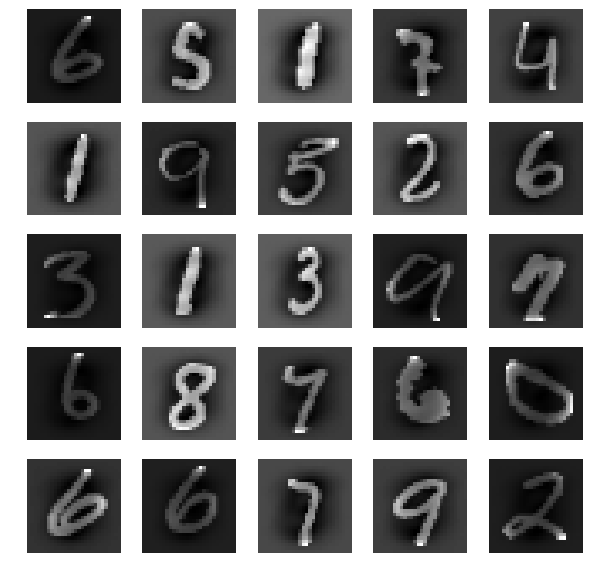

In [37]:
mnh.setup()
mnh.visualize()

In [38]:
print("Training set: X shape={xs}, y shape: {ys}".format(xs=mnh.X_train.shape, ys=mnh.y_train.shape) )
print("Training labels: y is of type {t}".format(t=type(mnh.y_train[0]) ) )

Training set: X shape=(5000, 784), y shape: (5000,)
Training labels: y is of type <class 'str'>


The training set $\X$ consists of 5000 examples, each having 784 features.

The 784 features are pixel intensity values (1=white, 0=black),  visualized as a $(28 \times 28)$ image.

Importantly, the labels (targets) are strings, i.e, string "0" rather than integer 0.
$$
C = \{ "0", "1", \ldots, "9" \}
$$

Let's fit a Logistic Regression model.

In [39]:
mnist_lr = mnh.fit()

Example run in 3.756 s


How did we do, i.e., what was the Performance Metric ?

In [40]:
clf = mnh.clf
score = clf.score(mnh.X_test, mnh.y_test)

# How many zero coefficients were forced by the penalty ?
sparsity = np.mean(clf.coef_ == 0) * 100

print("Test score with {p} penalty:{s:.2f}".format(p=clf.penalty, s=score) )
print("Sparsity with {p} penalty: {s:.2f}.".format(p=clf.penalty, s=sparsity) )

Test score with l2 penalty:0.87
Sparsity with l2 penalty: 15.43.


We achieved an accuracy on the Test set of about 88%.

Is this good ?  We'll probe that question in a later lecture.

For now: it sounds pretty good, but
- in a Test set with equal quantities of each digit
- we could get *all* instances of a single digit wrong and still achieve 90% accuracy !
- **Lesson**: absolute numbers are mis-leading

Also notice that `LogisticRegression` used an L2 penalty (Ridge Regression) that caused
about 16% of the parameters to become $0$.

How many parameters did we fit (i.e., what is the size of $\Theta$ ?

In [41]:
print("The classifier non-intercept parameters shape: {nc};  intercept parameters shape: {ni}".format(
    nc=mnh.clf.coef_.shape,
    ni=mnh.clf.intercept_.shape
)
     )


The classifier non-intercept parameters shape: (10, 784);  intercept parameters shape: (10,)


`sklearn` separately stores
- the intercept (`clf.intercept_`): the parameter associated with the `const` column in $\X'$)
- all other parameters (`clf.coef_`) 


As you can see from the leading dimension (10) there are essentially $||C||$ binary classifiers
- one parameter per element of the feature vector
- plus one intercept/constant parameter

In total $\Theta$ has $10*(784 + 1) = 7850$ parameters.

More precisely
- The target vector $\y$ is of length $||C|| = 10$, i.e., OHE target
    - we have previously only seen scalar targets
- `LogisticRegression` is performing One versus All (OvA) classification
- Because $||\y^\ip|| > 1$, it is using a Cross Entropy Loss in the cost function


Compare this to the KNN classifier from the first lecture
- one template per example, at $(28 \times 28) = 784$ parameters per example
- times $m = 5000$ examples

So the Logistic Classifier uses about $m = 5000$ times fewer parameters.

What do the 784 non-intercept parameters look like ?

That is: what is the "template" for each class (digit) ?

Since there is one parameter per pixel, ordered in the same way as the input image pixels, we can display the 784 parameters in a $(28 \times 28)$ image.

Remember: there is one parameter vector (template) for each of the $||C|| = 10$ classes.

/home/kjp/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


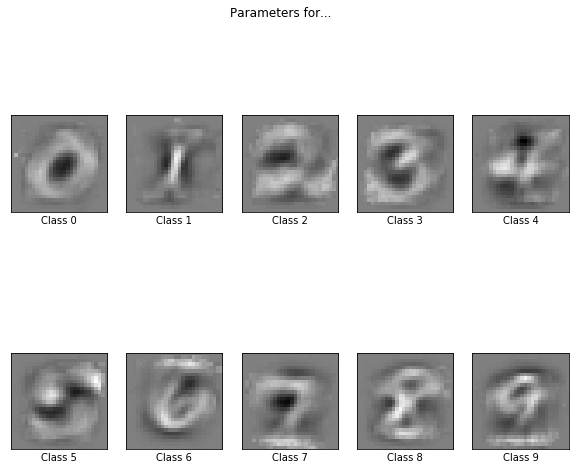

In [42]:
mnist_fig, mnist_ax = mnh.plot_coeff()

Our model learned a template, per digit, which hopefully captures the "essence" of the digit
- fuzzy, since it needs to match many possible examples of the digit, each written differently

We will "interpret" these coefficients in a subsequent lecture but, for now:
- dark colored parameters indicate the template for the pixel best matches dark input pixels
- bright colored parameters indicate the template for the pixel best matches bright input pixels

So the "essence" of an image representing the "1" digit is a vertical band of bright pixels.

<div class="alert alert-block alert-success">
<b>TIP</b>
    
The <font face=courier>fetch_mnist_784</font>
routine in the module takes a <b>long</b> time to execute.  Caching results makes you more productive.

</div>

## Error analysis: classifiction report, confusion matrix

For binary classification we are able to categorize the predictions on the test set into
- True Positives (TP), True negatives (TN)
    - correct predictions for Positive and Negative examples
- False Positives (FP), False Negatives (FN)
    - incorrectly labelled Positive and Negative Predictions
    
The *confusion matrix* generalizes this analysis to the multinomial case.



Normalized confusion matrix


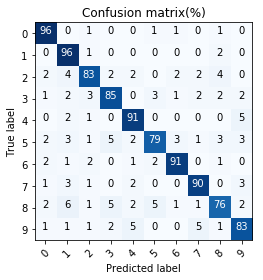

In [43]:
# Now predict the value of the digit on the second half:
confusion_mat = mnh.create_confusion_matrix()

digits = range(0,10)
_= clh.plot_confusion_matrix(confusion_mat, digits, normalize=True)

- The row labels are the (correct) targets
- The column labels are the predictions

The entry in the matrix for row $i$, column $j$
- fraction of test examples for class $i$ that were
predicted as class $j$.

So the diagonal entries correspond to correct predictions.

The off-diagonal entries are incorrect predictions, grouped by class.

From the confusion matrix: 
- our classifier is doing a great job recognizing the digit 0
- our classifier is struggling to recognize the digit 5
    - most often confusing it with the digit 3
- our classifier is struggling to recognize the digit 8
    - most often confusing it with the digits 5 and 1


### Show the math behind precison and recall

In [44]:
print("Confusion matrix shape: ", confusion_mat.shape)
print("Confusion matrix col sums: ", np.sum(confusion_mat, axis=0))
print("Confusion matrix row sums: ", np.sum(confusion_mat, axis=1))

# Compute recall by hand
for i in range(0,10):
    # True positives are on the diagonal
    TP = confusion_mat[i,i]
    
    # False positives
    # Column i contains the observations that were classified (correctly or incorrectly) as i
    FP =np.sum(confusion_mat, axis=0)[i] -TP
    
    num_true_i = np.sum(confusion_mat, axis=1)[i]
    num_classified_i = np.sum(confusion_mat, axis=0)[i]
    
    recall    = TP/num_true_i
    precision = TP/num_classified_i
    
    print("{i}: precision {p:3.2f}, recall {r:3.2f}".format(i=i, r=recall, p=precision) )

Confusion matrix shape:  (10, 10)
Confusion matrix col sums:  [1035 1342  915  959 1062  809  983 1040  881  974]
Confusion matrix row sums:  [ 993 1179  977  955 1005  884  998 1039  978  992]
0: precision 0.92, recall 0.96
1: precision 0.84, recall 0.96
2: precision 0.88, recall 0.83
3: precision 0.84, recall 0.85
4: precision 0.86, recall 0.91
5: precision 0.86, recall 0.79
6: precision 0.93, recall 0.91
7: precision 0.90, recall 0.90
8: precision 0.84, recall 0.76
9: precision 0.84, recall 0.83


### Confusion matrix

#### Recall is the diagonal of the normalized confusion matrix

# Logistic regression as Linear Regression of log odds

$$
\newcommand{\o}{\mathbf{o}}
$$

We can demonstrate a relationship between Logistic Regression and Linear Regression.

Recall the mapping of the score $\Theta^T \x$ into probabilities

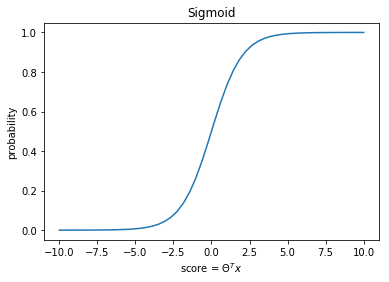

In [45]:
s = np.linspace(-10,10, 50)
sigma_s = 1/(1 + np.exp(- s))

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
_= ax.plot(s, sigma_s)
_= ax.set_title("Sigmoid")
_= ax.set_xlabel("score = $\Theta^T x$")
_= ax.set_ylabel("probability")

Certainly doesn't look like a linear relationship between scores and probability.

Define the *odds* $o^\ip$ of example $i$ being in class 1 as
$$o^\ip = \frac{\hat{p}^\ip}{1 - \hat{p}^\ip}$$
- the odds is just the ratio of the probability of being in class $1$ versus not being in class $1$

- **Note** this is called the *odds* **not** the odds ratio !
    - *odds ratio* is the ratio of two odds

Let's graph the relationship between scores $\Theta^T \x$ and the *log of the odds*.

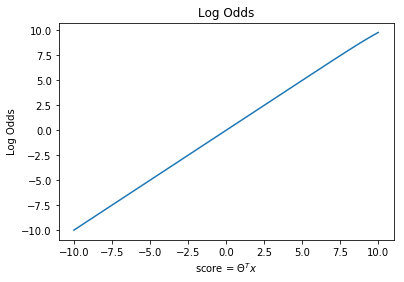

In [46]:
s = np.linspace(-10,10, 50)
sigma_s = 1/(1 + np.exp(- s))

p = sigma_s
epsilon = 10e-6

odds = p/(1 - p + epsilon)
log_odds = np.log(odds)

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
_= ax.plot(s, log_odds)
_= ax.set_title("Log Odds")
_= ax.set_xlabel("score = $\Theta^T x$")
_= ax.set_ylabel("Log Odds")

Linear !

So you can implement Logistic Regression as Linear Regression of the log odds versus features $\x$

This is similar in spirit to our transforming the "curvy" data set of the previous lesson
- there, we transformed features to obtain a linear relationship
- here we transformed the target

So the Logistic Regression equation is the linear equation
 $$\log(\o) = \Theta^T \x + \epsilon$$
   

In words:
- Logistic Regression is Linear Regression to predict log odds, given features $\x$ 

Knowing that the regression produces log odds will
become very useful in interpreting coefficients $\Theta$.

(Coming attraction: a unit change in $\Theta_j$ results in a *multiplicative* increase in odds)

### Log odds are normally distributed

Let's examine the distribution of log odds.

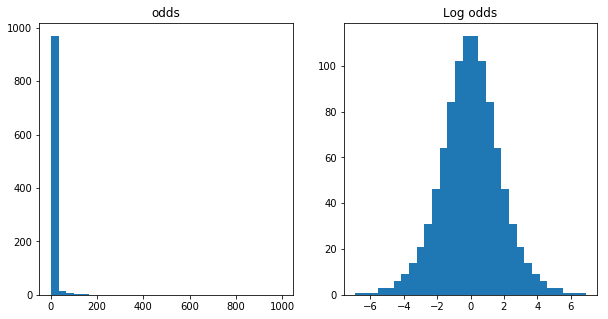

In [47]:
tf = tmh.TransformHelper()
tf.plot_odds()

- Log of the odds  is normally distributed
- Linear Regression errors will be normally distributed, satisfying model's mathematical assumptions 

## Logistic Regression as Linear Regression on the log odds: complication

Turns out you can't solve for the $\Theta$ in Logistic Regression by minimizing the RMSE cost function.
- Observe that
    - the log odds $\log(\frac{\hat{p}}{1 - \hat{p}}) =  \infty$ is  at $\hat{p} = 1$
    - the log odds $\log(\frac{\hat{p}}{1 - \hat{p}}) = - \infty$ is  at $\hat{p} = 0$

This will give infinite errors.

There is an alternate solution to Linear Regression using *Maximum Likelihood* which doesn't have
this issue.

n.b., Minimizing RMSE produces a Maximum Likelihood estimate of $\Theta$.

## Proof: log odds = score

Let
$$
\begin{array}[lll]\\
s  =  \Theta^T \x; &  \hat{p}   = \sigma(s)\\
\end{array}
$$
Then the odds $\o = \frac{\hat{p}}{1- \hat{p}}$ are
$$
\begin{array}{llll}
\hat{p} \over {1- \hat{p}} & = &  { 1 \over { 1 + e^{-s} } } \over { 1 -  {1 \over { 1 + e^{-s} } } } \\
& = & { 1 \over { 1 + e^{-s} } } \over { {1 + e^{-s}  -1} \over {1 + e^{-s}} } \\
& = & 1 \over {e^{-s}} \\
& = & e^{s}
\end{array}
$$

Thus the log odds
$$
\begin{array}[ll]\\
\log(\o) = s  \\
\log(\o) = \Theta^T \x & \text{since }  s = \Theta^T \x \\
\end{array}
$$



# Entropy, Cross Entropy, KL Diverence: deep dive

The Cross Entropy cost function is ominpresent in Machine Learning
as many problems involve matching probability distributions.

Although not strictly necessary, it may be interesting to explore this concept more deeply.


<div class="alert alert-block alert-warning">
    <b>TL;DR</b> 
    <ul>
        <li>Cross Entropy measures the "distance" between two distributions </li>
            <li>You will often come across Cross Entropy and KL Divergence in  your future ML endeavours.</li>
        </div> 

## Entropy

In order to understand *Cross* Entropy, we first try to explain *Entropy*.
- A measure of the randomness of a distribution
- Interpreted as the number of bits of information obtained from a single sample
- an alternative to Gini for deciding which variable/what threshold to use in constructing a Decision Tree

### What is a bit ?
- Amount of information need to reduce uncertainly by a factor of 2


#### Example: what is a bit

Here, a bit is the amount of information **not** a length of the message

**Simple case: two equally probable outcomes**

Two outcomes: Rain, Sun
$$    
\begin{array}{lll}
\text{Rain} & .5 \\
\text{Sun}  & .5
\end{array}
$$

Uncertainty about Rain is .5

If I tell you that it will Rain (so $p_{\text{Rain}}$ goes from $0.5$ to $1$)  the uncertainty is reduced
by a factor of
$$
{1 \over .5} = 2
$$

$\log_2 (2) = 1$ 

so this conveyed 1 bit of *information* regardless of how many *physical* bits were sent.

**Definition of a bit: Uncertainty reduction of a factor of 2**

One bit reduces uncertainty ($1/p$) by a factor of $2$.

$\log_2 (1/p) = - \log_2(p)$ 

**Simple case: 4 equally probable outcomes**

4 outcomes: Rain, Sun, Clouds, Drizzle
$$    
\begin{array}{lll}
\text{Rain} & .25 \\
\text{Sun}  & .25 \\
\text{Clouds} & .25 \\
\text{Drizzle} & .25
\end{array}
$$

Uncertainty about Rain is .25.


If I tell you that it will Rain (so $p_{\text{Rain}}$ goes from $0.25$ to $1$) I've reduced the uncertainty
by a factor of
$$
{1 \over .25} = 4
$$

This is $- \log_2 (.25) = 2$ bits of information.

**Outcomes with arbitrary probabilities**

Two outcomes with unequal probability: Rain, Sun
$$    
\begin{array}{lll}
\text{Rain} & .25 \\
\text{Sun}  & .75
\end{array}
$$

If I tell you that it will Rain (so $p_{\text{Rain}} = 1$) I've reduced the uncertainty
by
$$
{1 \over .25} = 4
$$

so this is $\log_2 (2) = 2$ bits of information.

If I tell you that there will be Sun (so $p_{\text{Sun}} = 1$) I've reduced the uncertainty
by
$$
{1 \over .75}
$$

so this is $- \log_2 (0.75) = 0.415$ bits of information.

In this case, the number of bits I convey to you is different depending on the message.

### Average number of bits in a sample

The average number of bits (*information*) in a sample randomly drawn from the distribution is

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$

For the 75%/25% case above

$
H_i = 0.75 * 0.415 + 0.25 * 2 = 0.81
$

25% of the time I give you 2 bits of information; 75% of the time only 0.415 bits 


This is also called the **entropy**

It measures the unpredictability of the distribution.

### A pure distribution has 0 entropy

Since $p_{i,k} = 1, log(p_{i,k}) = 0$

## Cross entropy

Whereas Entropy measured the randomness of a single distribution,
Cross Entropy measures the "distance" between two probability distributions $p$ and $q$.

We will call $p$ the *true* distribution and $q$ the estimated distribution.


**Cross entropy between two discrete probability distributions $p$ and $q$:**

$ H(p, q) = -\sum\limits_{x}p(x) \log q(x) $

 Similar to Entropy interpretation as weighted sum of bits but 
- uses true probability $p$ as weights
- uses estimated probability $q$ to measure the bits

If distributions $p(x), q(x)$ are the same
- cross entropy equals entropy: $H(p,p) = H(p)$

The difference 
$(H(p,q) - H(p))$ is called the *Kullback-Liebler* or KL divergence.

**Aside**

There is another interpretation of Cross Entropy.

We've seen that the amount of information depends on number of bits of each outcome $k$: $\log_2(p_{i,k})$.

$ H(p, q) = -\sum\limits_{x}p(x) \log q(x) $
is the average number of bits if information is given by $q$

If the number of bits  is different than $\log_2(p_{i,k})$
- then this message $q$ is *optimal* in length
    - only if the distribution is some other $q_{i,k}$
    
The physical length will equal the information content only if $p(x) = q(x)$




# Imbalanced datasets


**Problem**

We can define the *conditional accuracy of class* $c$ as the accuracy conditional on all
examples being from class $c$.

*Unconditional accuracy* is the accuracy measured on *all* examples in the set.
It is thus an equally weighted averge across examples

It is possible for unconditional accuracy to be high while conditional accuracy
for some class is low.

Consider the digit prediction task:
- assuming the distribution across the 10 classes is uniform
- we can consistently mispredict on a single digit (0% conditional accuracy)
- and still have an unconditional accuracy of 90% 

The distribution among the $|| C ||$ possible classes in $C$ is not always uniform.

This is called an *imbalanced* data set.

The problem of high unconditional accuracy with low conditional accuracy is most
acute for highly imbalanced data sets.

For the Titanic survival:
- only 38% of the passengers survived, so the dataset is highly imbalanced
- a naive model that *always* predicted "Not survived" will
    - have 62% accuracy
        - be correct 100% of the time for 62% of the sample (those that didn't survive)
        - be incorrect 100% of the time for 38% of the sample (those that did survive)

The question is whether your use case requiress high accuracy in *all* classes.

## Approaches to dealing with imbalanced data sets
- Use metrics other than unconditional accuracy
    - Precision, Recall
        - we use subsets of the confusion matrix to measure
        - Recall: fraction of True Positives versus True Examples
    - AUROC
    - Part of a good  Error Analysis
    - we will discuss these measures in a subsequent lecture
    

- Cost-sensitive training
    - modify the Performance Metric/Cost function to weight conditional probabilities
        - equally weighted across classes
            - `sklearn` inverse frequency weights
        - user-defined weights (`sklearn` optional `class_weights` argument to some classification models)
       
- Choose a model that is not sensitive to imbalance
    - Decision Trees
        - branching structure can handle imbalance

- Restore balance by resampling
    - oversample low frequency
    - undersample high frequency
    

# Recap

- We saw how to deal with categorical targets and features
- We saw some real-life transformations
    - We saw a real Data Transformation pipeline
        - feature union
        - was able to transform Pandas DataFrame !
        - Data cleaning via Imputer
        - One Hot Encoding

- Multiple models at no extra effort !
    - snuck in RandomForest and SVC classifiers - more later
    - only 1 line (instantiate model) changes !

- First pass at data cleaning - more later


In [48]:
print("Done")

Done
